In [1]:
import anndata as ad
import numpy as np
import scanpy as sc
from model.neighbors import neighbors
import matplotlib.pyplot as plt
from einops import rearrange

In [2]:
theta_n = 4
t_n = 150
theta = np.linspace(0,2,theta_n,endpoint=False)
t = np.linspace(1,5,t_n)
tth,tt = np.meshgrid(theta,t)
rotation = np.array([[np.cos(np.pi*tth),-np.sin(np.pi*tth)],[np.sin(np.pi*tth),np.cos(np.pi*tth)]])
arc = np.array([[tt*np.cos(tt)],[tt*np.sin(tt)]])
r = np.einsum('i j m n, j k m n -> i k m n', rotation,arc)
r = rearrange(r,'i k m n -> i k (n m)',k=1)
r = np.squeeze(r,axis=1).T
R = np.random.randn(100,2)
R = np.linalg.qr(R)[0]  # 正交化
embedded_data = r @ R.T
Z = np.random.randn(theta_n*t_n, 100)
eta  = (1-np.sin(3*tt.T.reshape(-1,1))**4)*Z / np.linalg.norm(Z,axis=1).reshape(-1,1)
noisy_data = embedded_data + eta
ad_data = ad.AnnData(X=noisy_data,obs={'theta':tth.T.reshape(-1),'time':tt.T.reshape(-1)})

/tmp/ipykernel_251714/2217140842.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


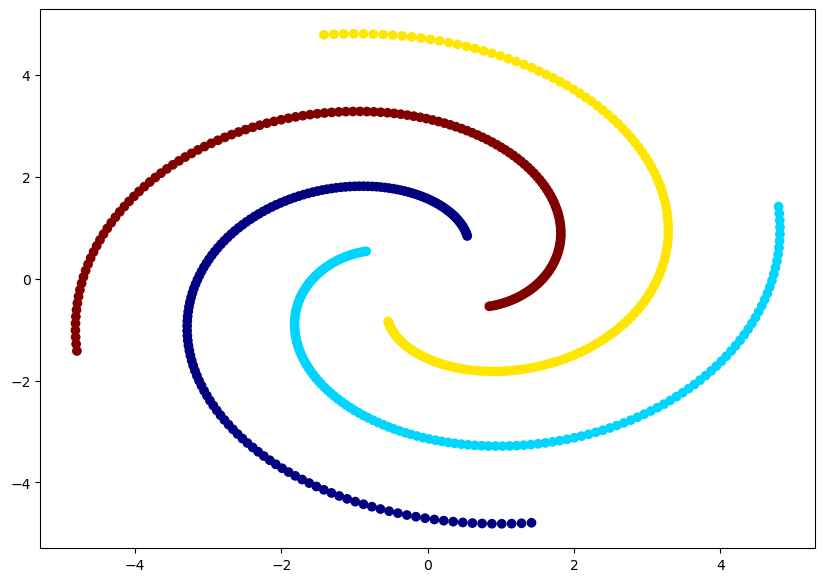

In [3]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
color = plt.cm.jet(tth.T.reshape(-1)/tth.max())
ax.scatter(r[:,0],r[:,1],c=color)
fig.show()

In [4]:
big_knn_ad = neighbors(ad_data,n_neighbors=20,n_initial_neighbors=20,use_rep='X',copy=True)
small_knn_ad = neighbors(ad_data,n_neighbors=5,n_initial_neighbors=5,use_rep='X',copy=True)
min_trimed_ad = neighbors(ad_data,n_neighbors=5,n_initial_neighbors=20,scheme="min",use_rep="X",copy=True)
max_trimed_ad = neighbors(ad_data,n_neighbors=5,n_initial_neighbors=20,scheme="max",use_rep="X",copy=True)

100%|██████████| 600/600 [00:24<00:00, 24.90it/s]


100%|██████████| 600/600 [00:17<00:00, 33.78it/s]


In [5]:
import networkx as nx
def drawGraph(adj,curvature):
    graph = nx.from_numpy_array(adj)
    curvature_graph = nx.from_numpy_array(curvature)
    edge_value = nx.get_edge_attributes(curvature_graph,'weight')
    edge_value = edge_value.values()
    nx.draw(graph,node_color='white',node_size=1,width=0.2,edge_color=edge_value,edge_cmap=plt.cm.viridis)
    plt.show()
    return

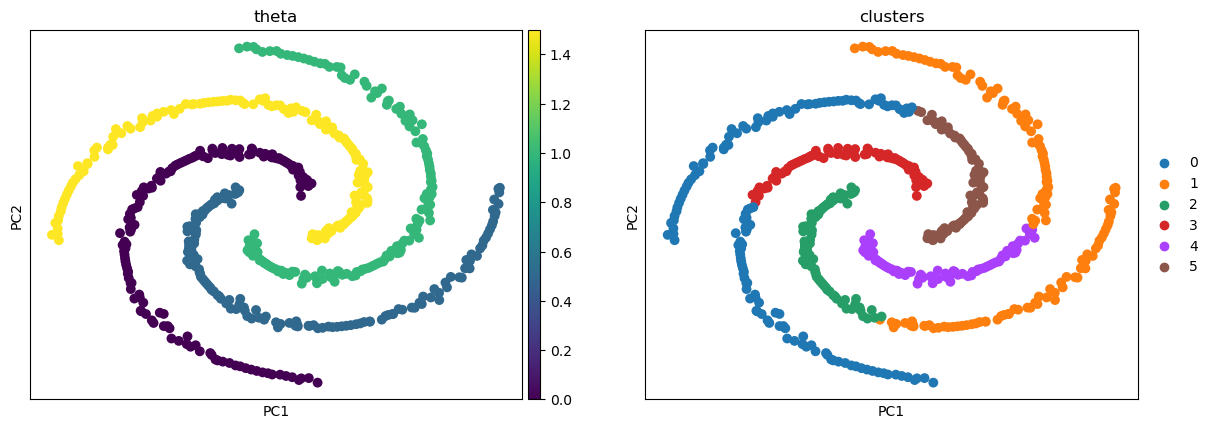

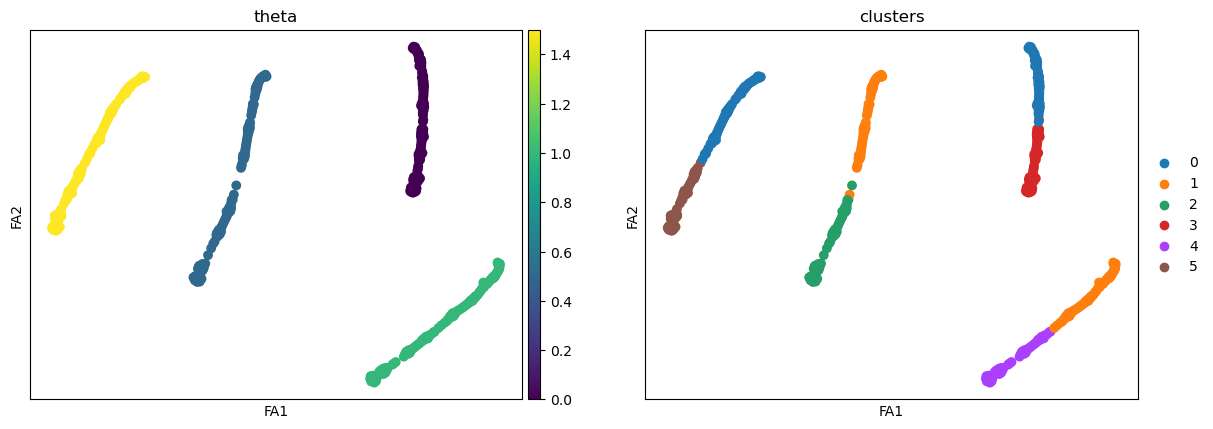

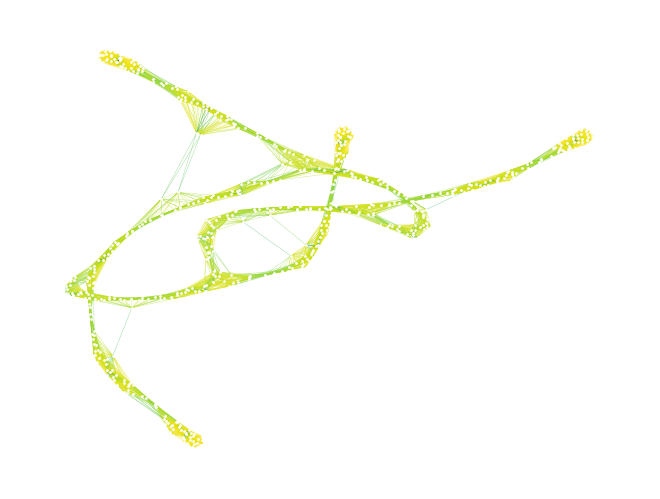

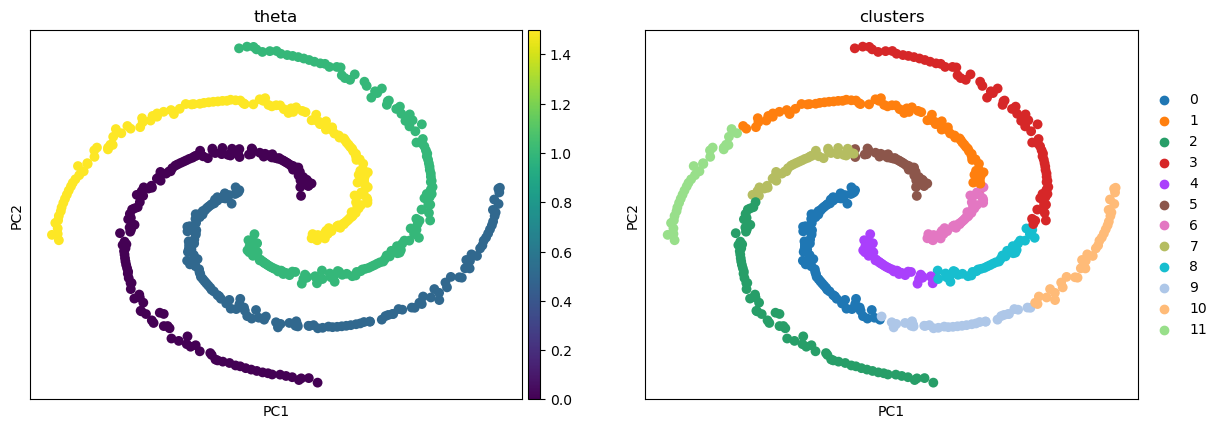

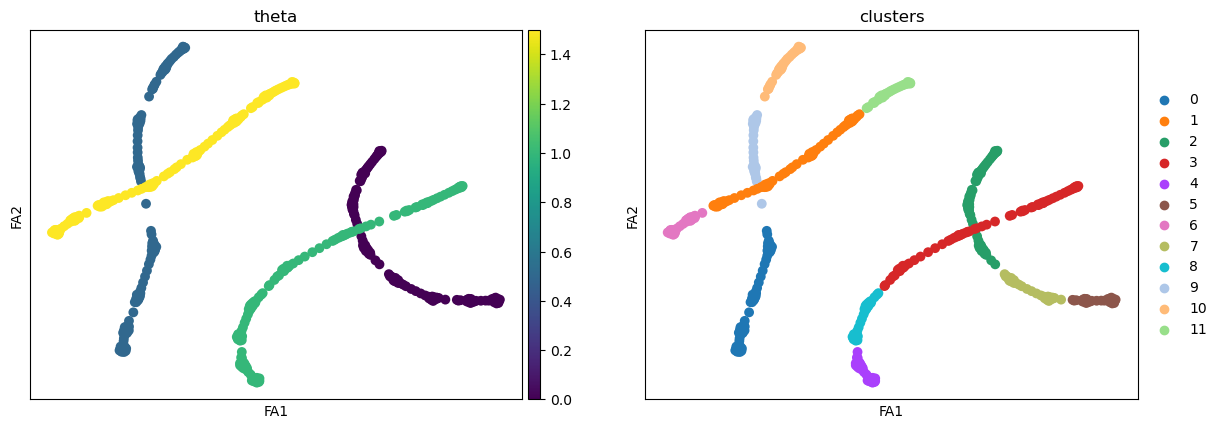

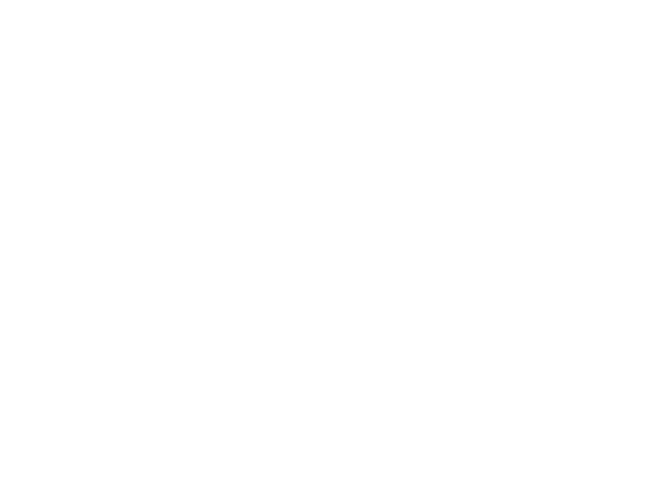

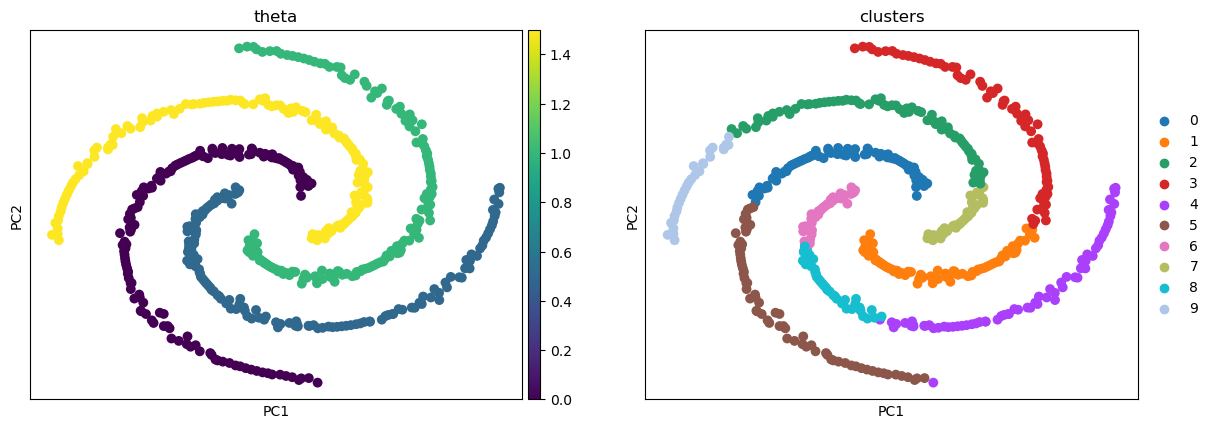

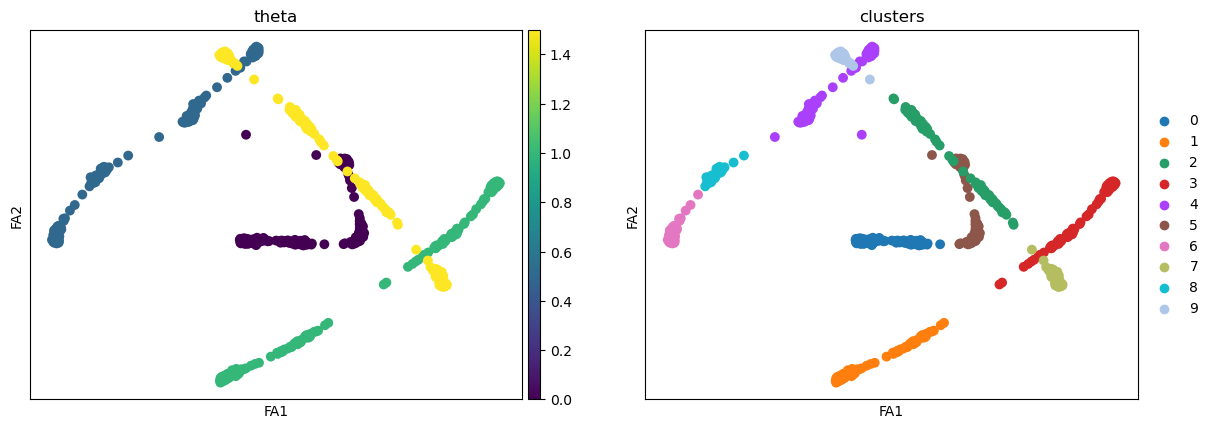

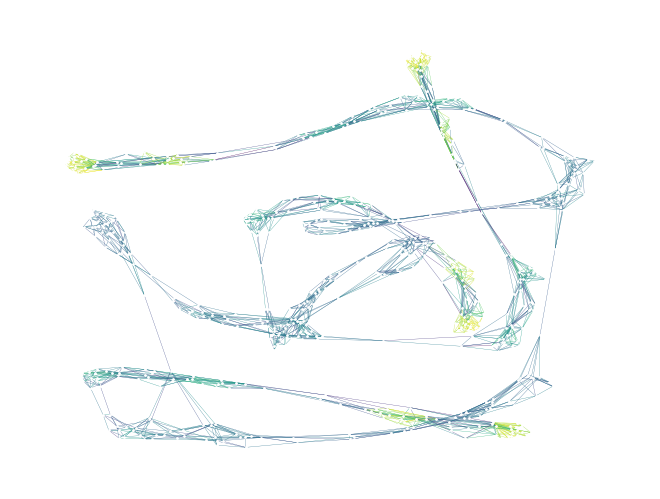

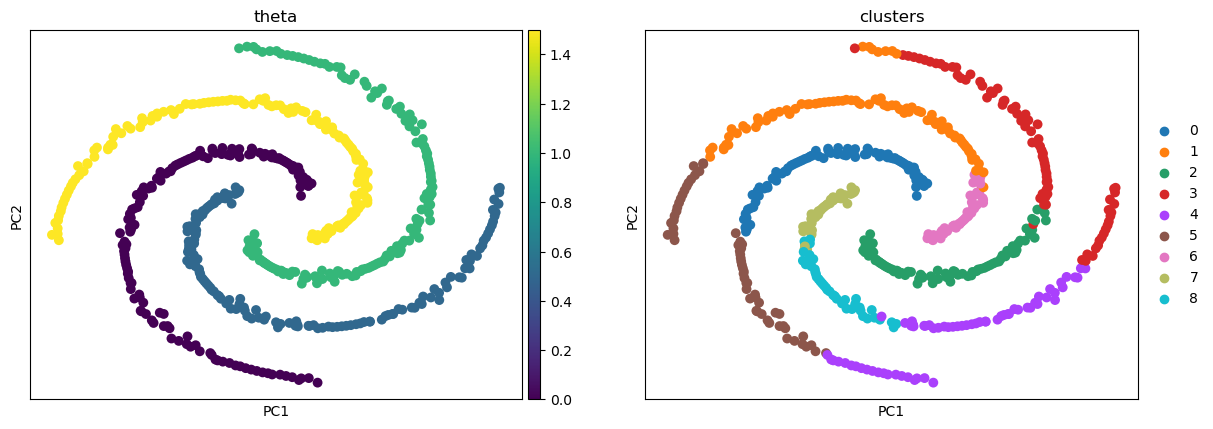

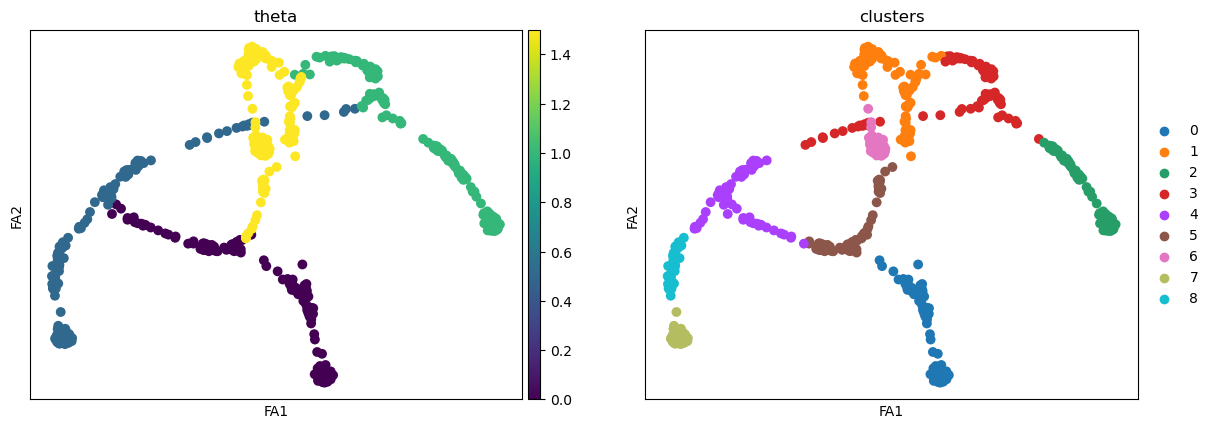

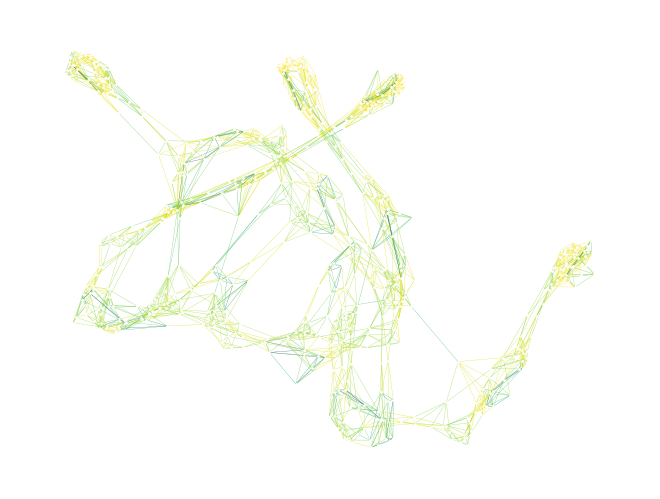

In [10]:
def plotad(point_ad):
    sc.tl.draw_graph(point_ad)
    sc.tl.louvain(adata=point_ad,resolution=0.2,key_added='clusters')
    sc.pp.pca(point_ad,n_comps=30)
    sc.pl.pca(point_ad,color=['theta','clusters'])
    sc.pl.draw_graph(point_ad,color=['theta','clusters'])
for ad in [big_knn_ad,small_knn_ad,min_trimed_ad,max_trimed_ad]:
    plotad(ad)
    drawGraph(ad.obsp["distances"],ad.obsp["curvature"])